In [1]:
from imp_act import make
from imp_act.environments.registry import Registry
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from pathlib import Path
import math
import re
from functools import lru_cache

## Collect environment information

In [2]:
# ---------------------------------------
# Collect environments from the registry.
# ---------------------------------------
def get_yaml_path(env_name: str) -> Path:
    _, params = reg[env_name]
    return Path(params["filename"])


@lru_cache(maxsize=None)
def get_env_cached(name: str):
    """Create/load an environment once per name (LRU cached)."""
    return make(name)


# Country code to pretty name mapping (ISO2)
ISO2_TO_NAME = {
    "AT": "Austria",
    "BE": "Belgium",
    "BG": "Bulgaria",
    "BY": "Belarus",
    "CH": "Switzerland",
    "CZ": "Czechia",
    "DE": "Germany",
    "DK": "Denmark",
    "EE": "Estonia",
    "ES": "Spain",
    "FI": "Finland",
    "FR": "France",
    "GR": "Greece",
    "HR": "Croatia",
    "HU": "Hungary",
    "IE": "Ireland",
    "IT": "Italy",
    "LT": "Lithuania",
    "LU": "Luxembourg",
    "LV": "Latvia",
    "MK": "North Macedonia",
    "NL": "Netherlands",
    "NO": "Norway",
    "PL": "Poland",
    "PT": "Portugal",
    "RO": "Romania",
    "RS": "Serbia",
    "RU": "Russia",
    "SE": "Sweden",
    "SI": "Slovenia",
    "SK": "Slovakia",
    "TR": "Turkey",
    "UA": "Ukraine",
    "UK": "United Kingdom",
}


def get_pretty_title(env_name: str) -> str:
    p = get_yaml_path(env_name)
    parent = p.parent.name
    stem = p.stem
    # Prefer full country name if parent folder is an ISO2 code we've mapped
    pretty = ISO2_TO_NAME.get(parent)
    if pretty is None and stem == parent and len(parent) == 2 and parent.isupper():
        # Fallback title-case if an unmapped 2-letter code appears
        pretty = parent.title()
    return pretty if pretty else env_name


# Include base '<dir>/<dir>.yaml' and any '*-v1.yaml'; exclude explicit '-jax'.
# Collect all registered environments; dedupe by YAML file so JAX variants collapse to one.
def is_candidate(name: str) -> bool:
    p = get_yaml_path(name)
    stem = p.stem
    parent = p.parent.name
    # Exclude unconstrained/budget variants
    if (
        stem.endswith("-unconstrained")
        or stem.endswith("-only-maintenance")
        or stem.endswith("-moderate-budget")
        or stem.endswith("-critical-budget")
    ):
        return False
    # Keep '-v1' stems and base country (filename equals its folder)
    return stem.endswith("-v1") or (stem == parent)


# Registry helper: resolve backing YAML path for a registered env name
reg = Registry()
candidates = [n for n in reg if is_candidate(n)]
# Deduplicate by YAML file name, preferring non-"-jax" names when both exist
unique_by_yaml = {}
for n in candidates:
    y = get_yaml_path(n).name
    if y not in unique_by_yaml:
        unique_by_yaml[y] = n
    else:
        # Prefer non-jax name
        if unique_by_yaml[y].endswith("-jax") and not n.endswith("-jax"):
            unique_by_yaml[y] = n
env_names = sorted(unique_by_yaml.values())

# -------------------------------------------
# Build env_df once using cached environments
# -------------------------------------------
_rows = []
for _name in env_names:
    _env = get_env_cached(_name)
    g = _env.graph
    _nodes = g.vcount()
    _edges = g.ecount()
    _density = float(g.density()) if _nodes > 1 else 0.0
    _avg_deg = float(np.mean(g.degree())) if _nodes else 0.0
    _comps = (
        len(g.connected_components(mode="weak"))
        if g.is_directed()
        else len(g.connected_components())
    )
    _trips = len(getattr(_env, "trips", []))
    _y = get_yaml_path(_name)
    segment_lengths = np.array(_env.graph.es["distance"])
    _rows.append(
        {
            "env_name": _name,
            "display_name": get_pretty_title(_name),
            "yaml_name": _y.name,
            "country_code": _y.parent.name,
            "nodes": _nodes,
            "edges": _edges,
            "density": _density,
            "avg_degree": _avg_deg,
            "connected_components": _comps,
            "trips": _trips,
            "budget_amount": getattr(
                _env,
                "budget_amount",
                _env.config["maintenance"].get("budget_amount", np.nan),
            ),
            "budget_interval": getattr(
                _env,
                "budget_renewal_interval",
                _env.config["maintenance"].get("budget_renewal_interval", np.nan),
            ),
            "reward_factor": _env.config["traffic"].get(
                "travel_time_reward_factor", np.nan
            ),
            "segment_length_mean": float(np.mean(segment_lengths)),
            "segment_length_max": float(np.max(segment_lengths)),
            "segment_length_cov": float(
                np.std(segment_lengths)
                / np.mean(segment_lengths)  # coefficient of variation
            ),
        }
    )
# global dataFrame with environment info for plotting
env_df = pd.DataFrame(_rows)

### Plotting function

In [3]:
def igraph_to_networkx(g):
    G = nx.DiGraph() if g.is_directed() else nx.Graph()
    G.add_nodes_from(range(g.vcount()))
    G.add_edges_from((e.source, e.target) for e in g.es)

    # copy vertex attrs
    for a in g.vs.attributes():
        nx.set_node_attributes(G, dict(enumerate(g.vs[a])), a)
    return G


def fmt_millions(x):
    try:
        m = float(x) / 1e6
    except Exception:
        return str(x)
    if m >= 100:
        return f"{int(round(m))}M"
    if m >= 10:
        return f"{m:.0f}M"
    return f"{m:.1f}M"


def plot_environment_summary(env_name: str, env_df: pd.DataFrame, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 3))

    env = get_env_cached(env_name)
    G = igraph_to_networkx(env.graph)

    px = nx.get_node_attributes(G, "position_x")
    py = nx.get_node_attributes(G, "position_y")
    pos = {i: (px[i], py[i]) for i in G.nodes()}

    ax.set_aspect("equal", adjustable="datalim")
    ax.set_axis_off()

    nx.draw_networkx_edges(G, pos, ax=ax, width=1.5, alpha=0.8, arrows=False)
    nx.draw_networkx_nodes(
        G,
        pos,
        ax=ax,
        node_size=20,
        node_color="#1f78b4",
        linewidths=0.5,
        edgecolors="black",
    )

    row = env_df.loc[env_df["env_name"] == env_name]
    if row.empty:
        raise ValueError(f"plot_environment_summary: env_df has no row for {env_name}")
    row = row.iloc[0]

    stats = {
        "nodes": f"nodes: {int(row.nodes)}",
        "edges": f"edges: {int(row.edges)}",
        "density": f"density: {float(row.density):.3f}",
        "avg_degree": f"avg_deg: {float(row.avg_degree):.2f}",
        "connected_components": f"connected_components: {int(row.connected_components)}",
        "segment_length_cov": f"segment_lengths_cov: {float(row.segment_length_cov):.3f}",
    }

    info = "\n".join(
        [
            "$\\mathbf{GENERAL}$",
            f"Reward factor: {row.reward_factor}",
            f"Budget: {fmt_millions(row.budget_amount)}",
            f"Trips: {int(row.trips)}",
            "",
            "$\\mathbf{GRAPH\\ STATS}$",
            *stats.values(),
        ]
    )

    ax.text(
        0.02,
        0.98,
        info,
        transform=ax.transAxes,
        va="top",
        ha="left",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8),
    )

    ax.set_title(f"{get_pretty_title(env_name)} ({row.yaml_name})", fontsize=10)
    return ax

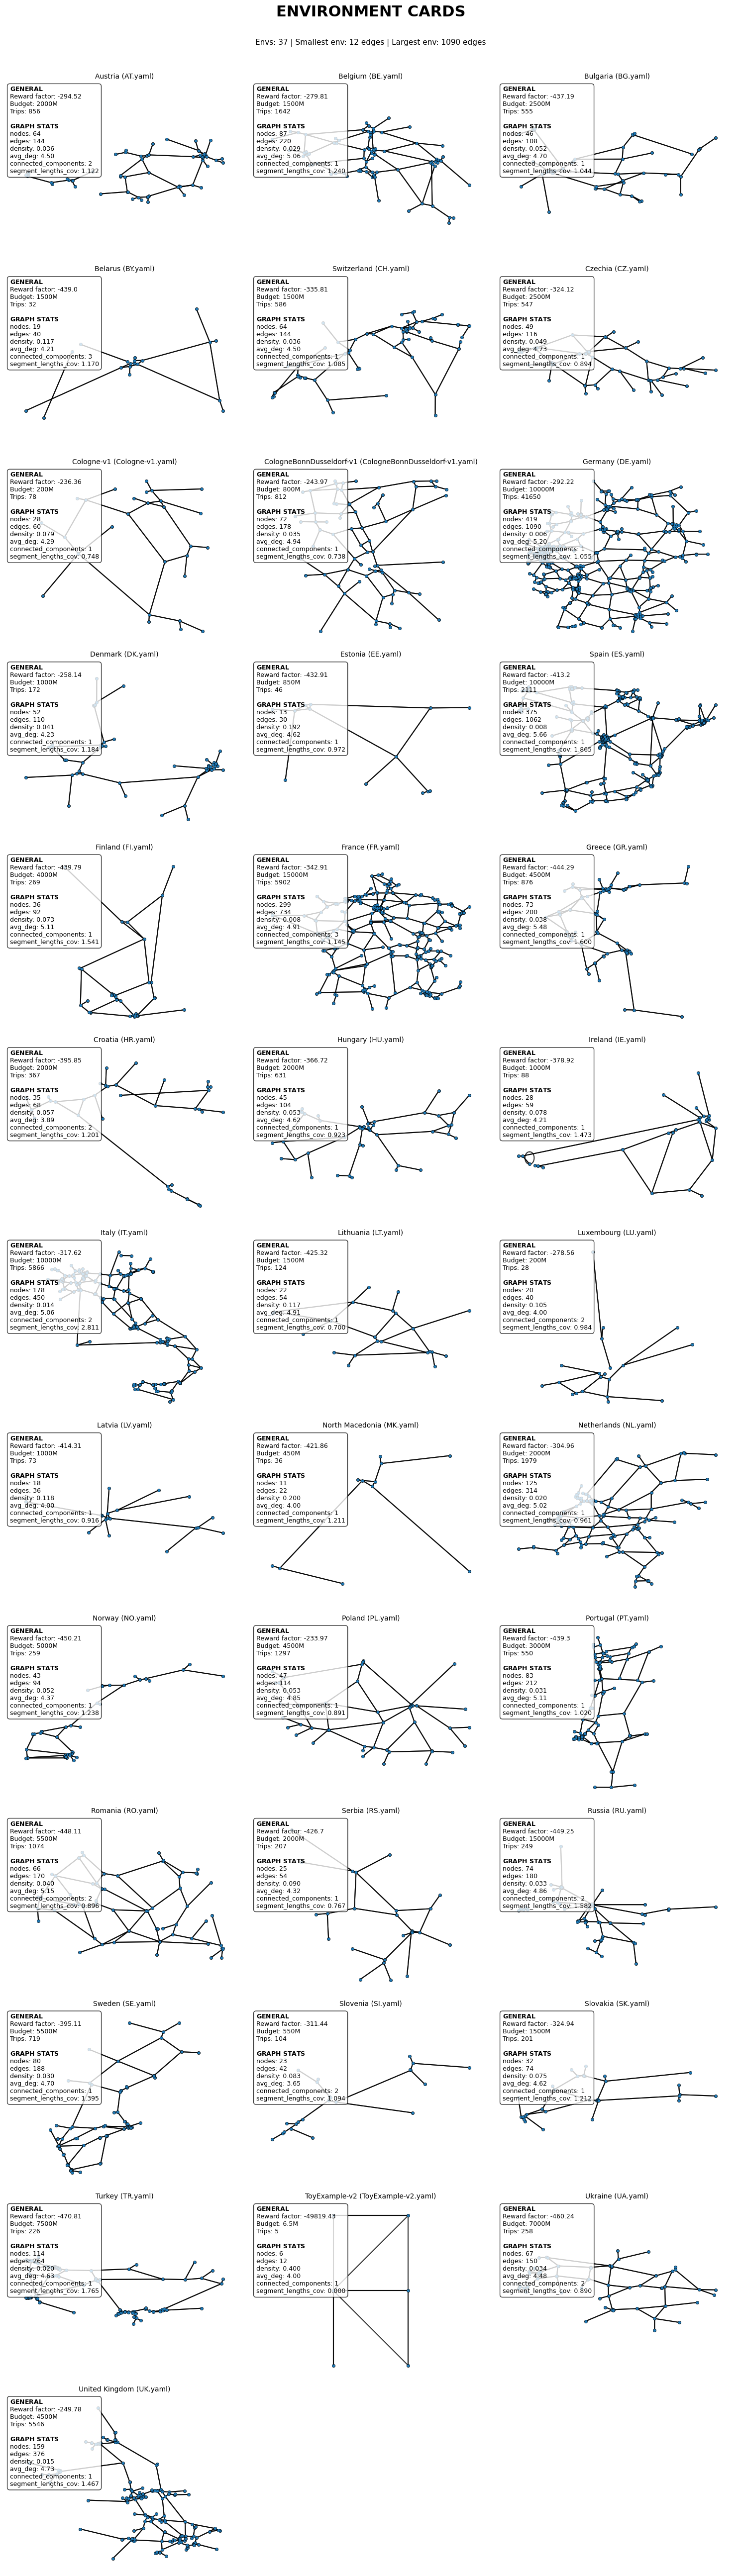

In [4]:
sizes_series = env_df.set_index("env_name").loc[env_names, "edges"]
_sizes = sizes_series.tolist()
N = len(env_names)
cols = 3
rows = math.ceil(N / cols) if N else 1
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
fig.suptitle("ENVIRONMENT CARDS", fontsize=22, fontweight="bold", y=0.995)
fig.text(
    0.5,
    0.982,
    f"Envs: {N} | Smallest env: {min(_sizes)} edges | Largest env: {max(_sizes)} edges",
    ha="center",
    va="top",
    fontsize=11,
)
axes = np.array(axes).reshape(rows, cols) if N > 1 else np.array([[axes]])

for idx, name in enumerate(env_names):
    r, c = divmod(idx, cols)
    plot_environment_summary(name, env_df, ax=axes[r, c])

# Hide any leftover axes
for blank in range(N, rows * cols):
    r, c = divmod(blank, cols)
    axes[r, c].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.98])

# Optional: save the figure
save_fig = True  # set True to save
if save_fig:
    save_dir = Path("./output")
    save_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(save_dir / "environment_cards.pdf", bbox_inches="tight")
plt.show()

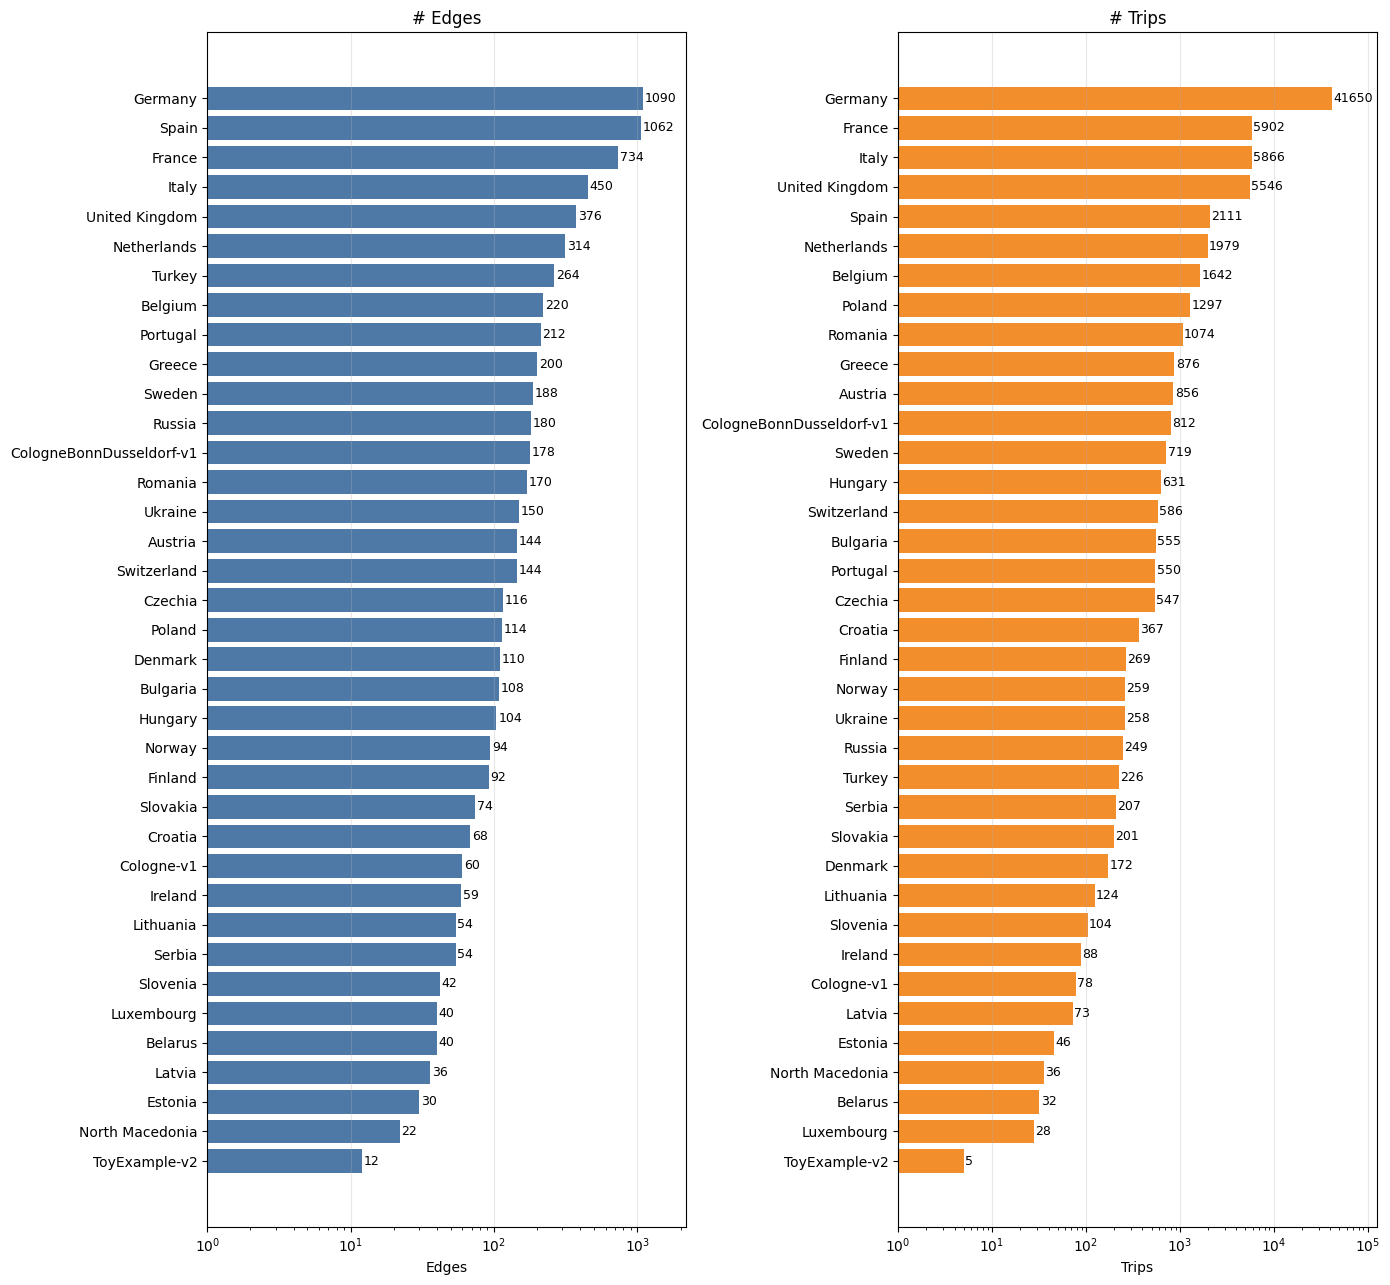

In [5]:
# Bar plots of environment sizes: #edges and #trips
_df = env_df.copy()

_edges_sorted = _df.sort_values("edges")[["display_name", "edges"]]
_trips_sorted = _df.sort_values("trips")[["display_name", "trips"]]

names_edges = _edges_sorted["display_name"].tolist()
vals_edges = _edges_sorted["edges"].tolist()

names_trips = _trips_sorted["display_name"].tolist()
vals_trips = _trips_sorted["trips"].tolist()

h = max(4, 0.35 * len(_df))
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, h))

bars1 = ax1.barh(names_edges, vals_edges, color="#4e79a7")
ax1.set_title("# Edges", fontsize=12)
ax1.set_xlabel("Edges")
ax1.set_xscale("log")

bars2 = ax2.barh(names_trips, vals_trips, color="#f28e2b")
ax2.set_title("# Trips", fontsize=12)
ax2.set_xlabel("Trips")
ax2.set_xscale("log")

# Always place labels just outside the bars (right side)
max_e = max(vals_edges) if len(vals_edges) else 1
max_t = max(vals_trips) if len(vals_trips) else 1
ax1.set_xlim(left=1, right=max_e * 2.0)
ax2.set_xlim(left=1, right=max_t * 3)
xmax1 = ax1.get_xlim()[1]
xmax2 = ax2.get_xlim()[1]
for rect, v in zip(bars1, vals_edges):
    y = rect.get_y() + rect.get_height() / 2
    ax1.text(
        min(v * 1.03, xmax1 * 0.95),
        y,
        f"{int(v)}",
        va="center",
        ha="left",
        color="black",
        fontsize=9,
    )
for rect, v in zip(bars2, vals_trips):
    y = rect.get_y() + rect.get_height() / 2
    ax2.text(
        min(v * 1.03, xmax2 * 0.95),
        y,
        f"{int(v)}",
        va="center",
        ha="left",
        color="black",
        fontsize=9,
    )

for ax in (ax1, ax2):
    ax.grid(axis="x", alpha=0.3)

plt.tight_layout()

# Optional: save the figure
save_fig = True  # set True to save
if save_fig:
    save_dir = Path("./output")
    save_dir.mkdir(parents=True, exist_ok=True)
    fig2.savefig(save_dir / "environment_sizes.pdf", bbox_inches="tight")

plt.show()